In [1]:
# import 
import pandas as pd 
import numpy as np
import sqlite3 as sq 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

%matplotlib inline

# to make prettier plots 
# from: https://blakeaw.github.io/2020-05-25-improve-matplotlib-notebook-inline-res/
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Project: Investigate a Dataset - [European Soccer Database]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#helper">Helper Functions</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitations">Limitations</a></li>
</ul>

<a id='intro'></a>
## Introduction


### Dataset Description 


_describe data_ 

The original project dealed only with `Player` and `Player_Attribute` tables. 


#### `Country` and `League` Tables

They both have 11 entries. The `Country` table has an `id` column and a `name` column. The columns of the `League` table are `id`, `country_id`, and `name`. This suggests to merge both tables. This is what we did below to get the new table `League` with columns `league_id`, `name`, and `country`. It has 11 rows. 

#### `Player` Table

The table has 11060 unique rows. The columns consists of three ID columns, they are all different as we see from the first few items of the table below. The `id` column seems to be a sorting id with no meaning. The `player_fifa_api_id` seems the most relevant here as this is the id column we are going to use to retrive the player attributes from the `Player_Attributes` table. The other columns are the player's name, birthday, height, and weight.

#### `Player_Attributes` Table

It has 183142 rows and 41 variables, and the variables' names are self-explainatory. We have 3 IDs columns as in the `Player` table. The other columns describe different skills of the player with a number between 1-100. The only exceptions are `date` and three columns; `preferred_foot`, `attacking_work_rate` and `defensive_work_rate`, where they are given strings value. We can treat them as categorical variables, with levels:

`preferred_foot`: right, left  
`attacking_work_rate`: low, medium, high  
`defensive_work_rate`: low, medium, high  


It is worth mentioing that every player receives a rating for every skill even though the skill might not be relevant to the player's position. For example, all players have ratings for GK skills. 

After cleaning, the table has 176161 rows for 9926 distinct players and 41 variables. 

### Questions for Analysis
_tentative_  
We are going to answer the following questions:
1) Who are the best (highest overall rating) players now and of all-time?
2) What are key factors of the best players?
3) Can we predict the overall rating of a player?
4) Is football a right-footed sport?

<a id='helper'></a>
## Helper Functions

In [2]:
def count_na_sql(table_name, conn, columns=[]):
    """
    some docstring 
    """
    if columns == []:
        table_info = pd.read_sql("PRAGMA table_info("+table_name+")", conn)
        columns = table_info['name']
    elif type(columns)==str:
        columns = [columns]
    
    # a dict to store values 
    count_na = {name: 0 for name in columns}
    for name in count_na:
        count_na[name] = conn.execute("SELECT COUNT(*) FROM "+table_name+" WHERE "+name+" IS NULL").fetchone()
    df = pd.DataFrame(count_na)
    return df


def summary_sql(table_name, conn): # this is like df.describe() in pandas 
    """
    describe numeric data 
    some docstring 
    """
    table_info = pd.read_sql("PRAGMA table_info("+table_name+")", conn)
    mask = np.logical_and(table_info['type'].str.contains("INTEGER|REAL"), (table_info['name'].str.contains('id')==False))
    summary = {name: 0 for name in table_info[mask]['name']}
    for name in summary:
        col_count = conn.execute("SELECT COUNT("+name+") FROM "+table_name).fetchone()[0] 
        col_na_count = conn.execute("SELECT COUNT(*) FROM "+table_name+" WHERE "+name+" IS NULL").fetchone()[0]
        col_mean = conn.execute("SELECT AVG("+name+") FROM "+table_name).fetchone()[0]
        col_min = conn.execute("SELECT MIN("+name+") FROM "+table_name).fetchone()[0]
        col_max = conn.execute("SELECT MAX("+name+") FROM "+table_name).fetchone()[0]
        summary[name] = [col_count, col_na_count, col_mean, col_min, col_max]
    index = ['count', 'NULL', 'mean', 'min', 'max']
    df = pd.DataFrame(summary, index= index)
    return df

def displ_options(df, how='head'):
    if how == 'display':
        display(df)
    elif how == 'print':
        print(df)
    elif how == 'head':
        display(df.head())

def max_dataframe(df, axis=-1, how='head'):
    if axis == -1:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
            displ_options(df, how)
    elif axis==0:
        with pd.option_context('display.max_rows', None):  
            displ_options(df, how)
    elif axis==1:
        with pd.option_context('display.max_columns', None):  
            displ_options(df, how)

def jitter(values,j):
    return values + np.random.normal(j,0.2,values.shape)

<a id='wrangling'></a>
## Data Wrangling

#### `Country` and `League` Tables

I prefered to do any data manipulation using on the SQLServer to practice my skills and to postpone loading tables into the memory as long as I can. We start by creating a connection to the database and gather information about the tables and their columns. 

In [3]:
conn = sq.connect('database.sqlite', isolation_level=None)
cur = conn.cursor()
# savepoint
cur.execute("SAVEPOINT originalDB")
tables_names = cur.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()
tables_info = {}
for name in tables_names:
    tab_name = name[0]
    df = pd.read_sql("PRAGMA table_info("+tab_name+")", conn)
    df.set_index('cid', drop=True, inplace=True)
    tables_info[tab_name] = df
    FKs = cur.execute("PRAGMA foreign_key_list("+tab_name+");").fetchall()
    df['fk'] = 0
    df['references'] = 0
    for FK in FKs:
        df.loc[df['name']==FK[3], 'fk'] = 1
        df.loc[df['name']==FK[3], 'references'] = FK[2]+"("+FK[4]+")"
    

In [4]:
tables_info.keys()

dict_keys(['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes'])

We start our process by looking at the `Country` and `League` tables, and we see that they both have the same number of rows. This suggests we join them into one table. We will join them and look at the number of rows in the the result of the `JOIN` oprtation to make sure we did not lose any information. 

In [5]:
tables_info['Country']

name     type  notnull dflt_value  pk  fk  references
cid                                                       
0      id  INTEGER        0       None   1   0           0
1    name     TEXT        0       None   0   0           0

In [6]:
tables_info['League']

name     type  notnull dflt_value  pk  fk   references
cid                                                              
0            id  INTEGER        0       None   1   0            0
1    country_id  INTEGER        0       None   0   1  country(id)
2          name     TEXT        0       None   0   0            0

In [7]:
pd.read_sql("""
            SELECT *
            FROM (SELECT COUNT(*) AS country_count 
            FROM Country) cc
            CROSS JOIN (SELECT COUNT(*) AS league_count
                        FROM League) lc
            """, conn)

country_count  league_count
0             11            11

In [8]:
# create a table in the database
cur.execute("""
    CREATE TABLE League_new AS
    SELECT l.id AS league_id, l.name, c.name AS country, l.country_id 
    FROM Country c 
    JOIN League AS l ON c.id = l.country_id
    """);

In [9]:
pd.read_sql("SELECT COUNT(*) AS country_league_count FROM League_new", conn)

country_league_count
0                    11

Now, we can drop both tables since we did not lose any information by joining them together, and rename the `League_new` table to be the `League` table. I avoided the use of the method `executescript()` because it issues a commit statement before it executes the SQL script and I do not want that in case I wanted to `ROLLBACK`.

In [10]:
cur.execute("DROP TABLE Country;")
cur.execute("DROP TABLE League;")
cur.execute("ALTER TABLE League_new RENAME TO League;");


Looking at the table below, We note that `country_id` and `league_id` are identical. We make sure of that and then drop one of them. 

In [11]:
diff_ids = cur.execute('SELECT COUNT(*) FROM League WHERE league_id<>country_id').fetchone()[0]
print(f'There are {diff_ids} rows with league_id!=country_id')

There are 0 rows with league_id!=country_id


In [12]:
cur.execute('ALTER TABLE League DROP COLUMN country_id');

#### `Player` table

The `Player` table has no missing values. The weight column seems to be in Pounds, we convert it to Kg.

In [13]:
pd.read_sql("SELECT * FROM Player LIMIT 5", conn) #they are different 

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

In [14]:
df = count_na_sql("Player", conn)
df.head()

id  player_api_id  player_name  player_fifa_api_id  birthday  height  \
0   0              0            0                   0         0       0   

   weight  
0       0

In [15]:
cur.execute("""
            ALTER TABLE Player 
            ADD COLUMN weight_kg AS (0.45359237*weight) 
            """); # can't use ROUND since sqlite computed columns can not contain windows functions


In [16]:
NUM_PLAYER_FROM_PLAYER = cur.execute('SELECT COUNT(*) FROM player').fetchone()[0]

#### `Player_Attributes` table

We now turn to the `Player_Attributes` table. We note that almost all the columns are missing 836 values. We try to examin this data and find if they are simialr for all columns. We found that the table has all values of the player attributes are missing for these 836 rows. We will drop them, so the `Player_Attributes` table now has 182306 rows. We look at other missing values. 



In [17]:
player_attributes_na = count_na_sql("Player_Attributes", conn)
max_dataframe(player_attributes_na, 1, 'display')

id  player_fifa_api_id  player_api_id  date  overall_rating  potential  \
0   0                   0              0     0             836        836   

   preferred_foot  attacking_work_rate  defensive_work_rate  crossing  \
0             836                 3230                  836       836   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0        836               836            836     2713        836   2713   

   free_kick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                 836           836           836           836           836   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0     2713        836     2713         836     2713      836       836   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0         836         836            836          836    2713        836   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0      836              836            2713        836          836   

   gk_kicking  gk_positioning  gk_reflexes  
0         836             836          836

In [18]:
cur.execute('DROP TABLE IF EXISTS temp')

cur.execute('''
            CREATE TABLE temp AS
            SELECT * 
            FROM Player_Attributes 
            WHERE overall_rating IS NULL''')

names_na = [name for name in player_attributes_na if name not in ['id', 'player_fifa_api_id', 'player_api_id', 'date']]
sum_not_na = 0
for name in names_na:
    sum_not_na += cur.execute('SELECT COUNT(*) FROM temp WHERE '+name+' IS NOT NULL').fetchone()[0]
print(f'number of rows with non-null values is : {sum_not_na}')

number of rows with non-null values is : 0


In [19]:
cur.execute('DELETE FROM Player_Attributes WHERE overall_rating IS NULL')
player_attributes_na = count_na_sql("Player_Attributes", conn)
index = []
for name in player_attributes_na.columns:
    if player_attributes_na[name][0] != 0: # columns with null values
        index.append(name)
display(player_attributes_na[index])




attacking_work_rate  volleys  curve  agility  balance  jumping  vision  \
0                 2394     1877   1877     1877     1877     1877    1877   

   sliding_tackle  
0            1877

The columns with missing values seems to have something in common. We start with `volleys` column. When we look at them, we notice that the data for `defensive_work_rate` are also missing but they were incorrrectly encoded as `TEXT`. We made sure that the result of our query includes all missing values of the columns showing in the above table except maybe for `attacking_work_rate`.

I could not find a good way to replace the data because the players with missing values in these columns do not have values at all in the same columns, so I could not infere the data. I could have replaced them with the `overall_rating` of the player, but this might result in a very good defender (consequently high `overall_rating`) having very good `curve` or `volleys` ratings which is not common. 

We plotted a histogram of the `overall_rating`, and we found that the missing values approximately follow a normal distribution. Given that these rows accounts for 1.02% of the data, and they follow a normal distribution, we decide that is safe to omit them and move forward. 

In [20]:
na_rows = pd.read_sql('SELECT * FROM Player_Attributes WHERE volleys IS NULL', conn)
max_dataframe(na_rows, 1, 'display')

id  player_fifa_api_id  player_api_id                 date  \
0        447               52782          38423  2010-02-22 00:00:00   
1        448               52782          38423  2009-08-30 00:00:00   
2        449               52782          38423  2008-08-30 00:00:00   
3        450               52782          38423  2007-08-30 00:00:00   
4        451               52782          38423  2007-02-22 00:00:00   
...      ...                 ...            ...                  ...   
1872  183493              177901          45308  2007-02-22 00:00:00   
1873  183536               51883          30850  2009-02-22 00:00:00   
1874  183537               51883          30850  2008-08-30 00:00:00   
1875  183538               51883          30850  2007-08-30 00:00:00   
1876  183539               51883          30850  2007-02-22 00:00:00   

      overall_rating  potential preferred_foot attacking_work_rate  \
0                 68         70          right                None   
1                 68         70          right                None   
2                 68         69          right                None   
3                 70         69          right                None   
4                 70         69          right                None   
...              ...        ...            ...                 ...   
1872              64         65          right                None   
1873              73         81          right                None   
1874              77         81          right                None   
1875              70         80          right                None   
1876              70         80          right                None   

     defensive_work_rate  crossing  finishing  heading_accuracy  \
0                     _0        60         50                60   
1                     _0        60         50                60   
2                     _0        60         50                60   
3                     _0        60         50                60   
4                     _0        60         50                70   
...                  ...       ...        ...               ...   
1872                  _0        41         62                62   
1873                   o        20         20                28   
1874                   o        20         20                28   
1875                   o        40         38                48   
1876                   o        40         38                48   

      short_passing volleys  dribbling curve  free_kick_accuracy  \
0                74    None         74  None                  53   
1                74    None         74  None                  53   
2                74    None         74  None                  53   
3                74    None         74  None                  53   
4                74    None         74  None                  47   
...             ...     ...        ...   ...                 ...   
1872             64    None         65  None                  69   
1873             32    None         20  None                  12   
1874             32    None         20  None                  12   
1875             48    None         38  None                   8   
1876             48    None         38  None                  56   

      long_passing  ball_control  acceleration  sprint_speed agility  \
0               62            73            74            70    None   
1               62            73            74            70    None   
2               62            73            74            70    None   
3               62            73            74            70    None   
4               62            73            76            70    None   
...            ...           ...           ...           ...     ...   
1872            51            66            65            66    None   
1873            71            30            52            38    None   
1874            78            30  

In [21]:
# count non-null values
names_na = [name for name in index if name!='attacking_work_rate']
sum_not_na = 0
for name in names_na:
    sum_not_na += sum(~na_rows[name].isna())
print(f'number of rows with non-null values is : {sum_not_na}')

number of rows with non-null values is : 0


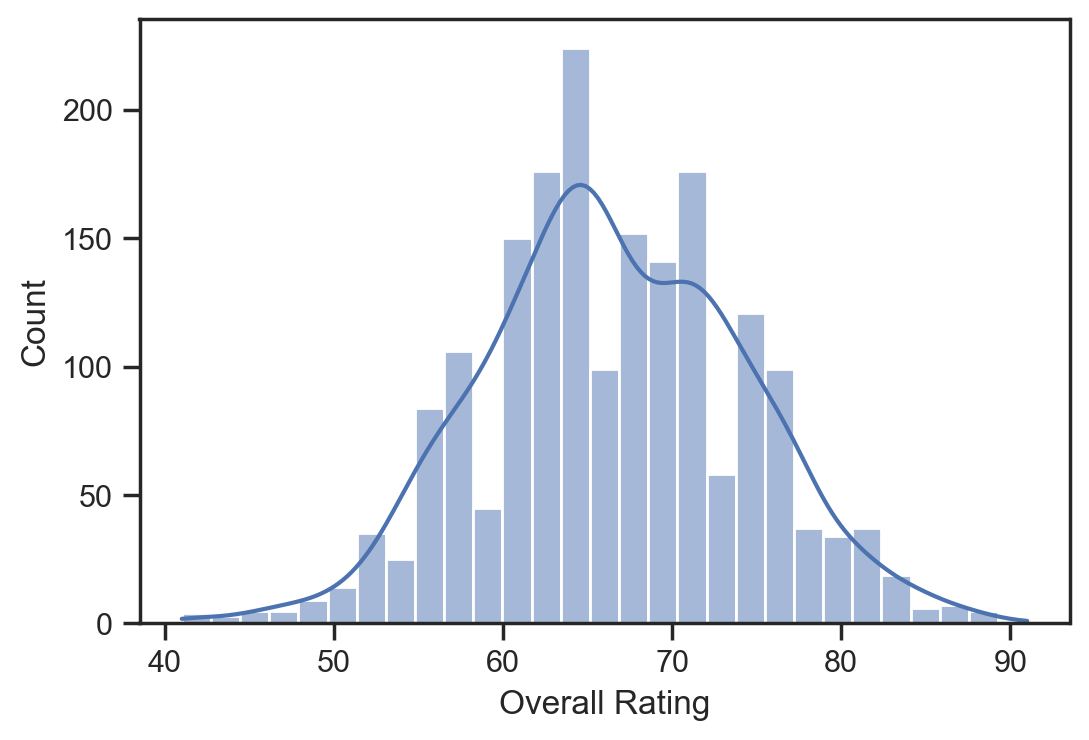

percentage of the rows with NULL values in the columns: ['volleys', 'curve', 'agility', 'balance', 'jumping', 'vision', 'sliding_tackle'] is:
  1.02%


In [22]:
sns.histplot(na_rows['overall_rating'], kde=True)
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()
INIT_NUM_ROW_PLAYER_ATTR = cur.execute('SELECT COUNT(*) FROM Player_Attributes').fetchone()[0]
percent = 100* na_rows.shape[0]/INIT_NUM_ROW_PLAYER_ATTR
col_names = [col for col in index if col!= 'attacking_work_rate'] # this is the index we used to find the current info about NULL values
print(f'percentage of the rows with NULL values in the columns: {col_names} is:\n {percent: .2f}%' )

In [23]:
cur.execute('DELETE FROM Player_Attributes WHERE volleys IS NULL');

The remainig `NULL` values are in the `attacking_work_rate`. We, again, notice that the data for `defensive_work_rate` is also missing but it was incorrrectly encoded as `TEXT`. They all are given `_0` value. We change it no `NULL` to handle them. This might change the number of `NULL` values in the column. 


In [24]:
player_attributes_na = count_na_sql("Player_Attributes", conn, columns=['attacking_work_rate'])
display(player_attributes_na)

# have a look
na_rows = pd.read_sql('SELECT * FROM Player_Attributes WHERE attacking_work_rate IS NULL', conn)
max_dataframe(na_rows, 1, 'display')

attacking_work_rate
0                  911

id  player_fifa_api_id  player_api_id                 date  \
0       374              156626          46447  2010-08-30 00:00:00   
1       375              156626          46447  2010-02-22 00:00:00   
2       376              156626          46447  2008-08-30 00:00:00   
3       377              156626          46447  2007-08-30 00:00:00   
4       378              156626          46447  2007-02-22 00:00:00   
..      ...                 ...            ...                  ...   
906  183964               47058          35506  2009-08-30 00:00:00   
907  183965               47058          35506  2009-02-22 00:00:00   
908  183966               47058          35506  2008-08-30 00:00:00   
909  183967               47058          35506  2007-08-30 00:00:00   
910  183968               47058          35506  2007-02-22 00:00:00   

     overall_rating  potential preferred_foot attacking_work_rate  \
0                64         71          right                None   
1                64         71          right                None   
2                66         71          right                None   
3                68         75          right                None   
4                66         65          right                None   
..              ...        ...            ...                 ...   
906              70         78          right                None   
907              70         78          right                None   
908              72         78          right                None   
909              75         78          right                None   
910              78         79          right                None   

    defensive_work_rate  crossing  finishing  heading_accuracy  short_passing  \
0                    _0        41         33                74             57   
1                    _0        41         33                74             57   
2                    _0        41         33                74             57   
3                    _0        41         33                74             57   
4                    _0        41         33                70             51   
..                  ...       ...        ...               ...            ...   
906                  _0        48         43                79             59   
907                  _0        48         43                79             59   
908                  _0        48         43                79             59   
909                  _0        48         43                79             59   
910                  _0        38         43                79             58   

     volleys  dribbling  curve  free_kick_accuracy  long_passing  \
0         24         30     35                  40            45   
1         24         30     35                  40            45   
2         24         30     35                  40            45   
3         24         30     35                  40            45   
4         24         30     35                  55            45   
..       ...        ...    ...                 ...           ...   
906       59         36     29                  37            51   
907       59         36     29                  37            51   
908       59         36     29                  37            51   
909       59         36     29                  37            51   
910       59         36     29                  72            48   

     ball_control  acceleration  sprint_speed  agility  reactions  balance  \
0              44            60            61       59         58       73   
1              44            60            61       59         58       73   
2              44            60            61       59         58       73   
3              44            60            61       59         62       73   
4              44            60            61       59         62       73   
..            ...           ...           ...      ...        ...    

In [25]:
all(na_rows['defensive_work_rate'] == '_0')


True

In [26]:
cur.execute('''UPDATE Player_Attributes
            SET defensive_work_rate = NULL
            WHERE defensive_work_rate = '_0'
            ''');
player_attributes_na = count_na_sql("Player_Attributes", conn, columns=['attacking_work_rate', 'defensive_work_rate'])
display(player_attributes_na)

attacking_work_rate  defensive_work_rate
0                  911                  911

This means that rows with values `_0` in the `defensive_work_rate` are the same as rows with `NULL` values of `attacking_work_rate`. As before, players with missing data do not have any data in these columns. Since they are 0.5% of the original data and they follow a normal distribution, we decide to delete them. This means we deleted 1.52% of the data so far. 

In [27]:
cur.execute('DROP TABLE IF EXISTS temp')

cur.execute('''
            CREATE TABLE temp AS
            SELECT *
            FROM Player_Attributes t1
            JOIN (SELECT player_fifa_api_id
                        FROM Player_Attributes 
                        WHERE attacking_work_rate IS NULL) t2
            ON t1.player_fifa_api_id = t2.player_fifa_api_id
            ''')
# count non-null values
names_na = ['attacking_work_rate', 'defensive_work_rate']
sum_not_na = 0
for name in names_na:
    sum_not_na += cur.execute('SELECT COUNT(*) FROM temp WHERE '+name+' IS NOT NULL').fetchone()[0]
print(f'number of rows with non-null values is : {sum_not_na}')

number of rows with non-null values is : 0


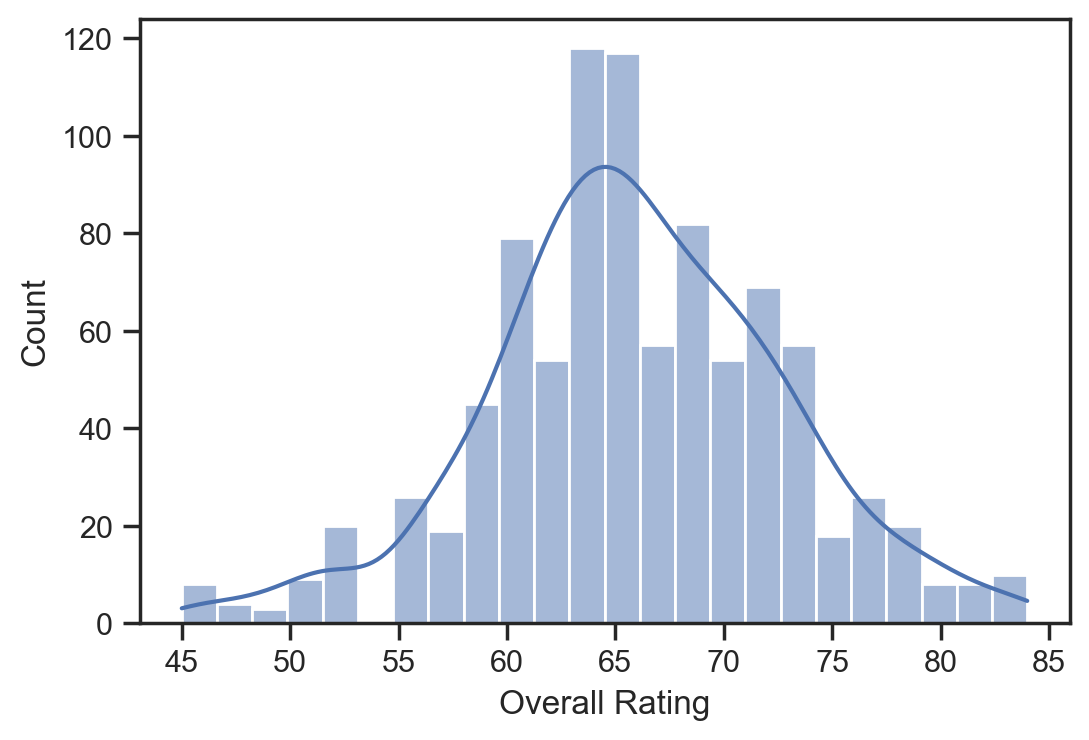

percentage of the rows with NULL values in the attacking_work_rate columns is:
 0.50%


In [28]:
sns.histplot(na_rows['overall_rating'], kde=True)
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()
percent = 100* na_rows.shape[0]/INIT_NUM_ROW_PLAYER_ATTR
print(f'percentage of the rows with NULL values in the attacking_work_rate columns is:\n{percent: .2f}%' )

In [29]:
# delete them 
cur.execute('DELETE FROM Player_Attributes WHERE attacking_work_rate IS NULL');

To ensure that the data is clean let's look at summary of the columns. From the numeric values, I defined a function `summary_sql()` that produce simialr results as `pandas.DataFrame.describe()`. The data from summary looks clean; no missing values and all columns vary from a minimum value to 100. Next, we look at the `attacking_work_rate` and `defensive_work_rate` columns.  

In [30]:
max_dataframe(summary_sql('Player_Attributes', conn))

overall_rating      potential       crossing      finishing  \
count   180354.000000  180354.000000  180354.000000  180354.000000   
NULL         0.000000       0.000000       0.000000       0.000000   
mean        68.635317      73.479457      55.142071      49.962136   
min         33.000000      39.000000       1.000000       1.000000   
max         94.000000      97.000000      95.000000      97.000000   

       heading_accuracy  short_passing        volleys      dribbling  \
count     180354.000000  180354.000000  180354.000000  180354.000000   
NULL           0.000000       0.000000       0.000000       0.000000   
mean          57.263476      62.486726      49.488927      59.265755   
min            1.000000       3.000000       1.000000       1.000000   
max           98.000000      97.000000      93.000000      97.000000   

               curve  free_kick_accuracy   long_passing   ball_control  \
count  180354.000000       180354.000000  180354.000000  180354.000000   
NULL        0.000000            0.000000       0.000000       0.000000   
mean       53.001408           49.392783      57.084578      63.453846   
min         2.000000            1.000000       3.000000       5.000000   
max        94.000000           97.000000      97.000000      97.000000   

        acceleration   sprint_speed        agility      reactions  \
count  180354.000000  180354.000000  180354.000000  180354.000000   
NULL        0.000000       0.000000       0.000000       0.000000   
mean       67.709405      68.101628      65.995082      66.148297   
min        10.000000      12.000000      11.000000      17.000000   
max        97.000000      97.000000      96.000000      96.000000   

             balance     shot_power        jumping        stamina  \
count  180354.000000  180354.000000  180354.000000  180354.000000   
NULL        0.000000       0.000000       0.000000       0.000000   
mean       65.190082      61.866474      66.977333      67.053401   
min        12.000000       2.000000      14.000000      10.000000   
max        96.000000      97.000000      96.000000      96.000000   

            strength    long_shots     aggression  interceptions  \
count  180354.000000  180354.00000  180354.000000  180354.000000   
NULL        0.000000       0.00000       0.000000       0.000000   
mean       67.432477      53.38756      60.946217      51.897374   
min        10.000000       1.00000       6.000000       1.000000   
max        96.000000      96.00000      97.000000      96.000000   

        positioning         vision      penalties        marking  \
count  180354.00000  180354.000000  180354.000000  180354.000000   
NULL        0.00000       0.000000       0.000000       0.000000   
mean       55.73073      57.868176      54.933448      46.757433   
min         2.00000       1.000000       2.000000       1.000000   
max        95.00000      97.000000      96.000000      94.000000   

       standing_tackle      gk_diving    gk_handling     gk_kicking  \
count    180354.000000  180354.000000  180354.000000  180354.000000   
NULL          0.000000       0.000000       0.000000       0.000000   
mean         50.354065      14.696685      15.947786      20.526304   
min           1.000000       1.000000       1.000000       1.000000   
max          95.000000      94.000000      93.000000      97.000000   

       gk_positioning   gk_reflexes  
count   180354.000000  180354.00000  
NULL         0.000000       0.00000  
mean        16.015043      16.32531  
min          1.000000       1.00000  
max         96.000000      96.00000

In [31]:
pd.read_sql("""
            SELECT attacking_work_rate, COUNT(*) AS counts 
            FROM Player_Attributes 
            GROUP BY attacking_work_rate
            ORDER BY counts DESC""", conn)

attacking_work_rate  counts
0              medium  125070
1                high   42823
2                 low    8569
3                None    3317
4                norm     317
5                   y      94
6                stoc      86
7                  le      78

In [32]:
pd.read_sql("""
            SELECT defensive_work_rate, COUNT(*) AS counts 
            FROM Player_Attributes 
            GROUP BY defensive_work_rate
            ORDER BY counts DESC""", conn)

defensive_work_rate  counts
0               medium  130846
1                 high   27041
2                  low   18432
3                    o    1328
4                    1     421
5                    2     334
6                ormal     317
7                    3     243
8                    5     231
9                    7     207
10                   0     188
11                   6     179
12                   9     143
13                   4     116
14                  es      94
15               tocky      86
16                 ean      78
17                   8      70

We print them in more readable way. At this point, I am tired. The `other` entries consist of around 2.29% of the original data and they follow a normal distribution, so I am going to delete them. I might come back in future to try to mutate them. This leaves us with `(100 - 1.05 - 0.5 - 2.29)% = 96.16%` of the data. This is a very good portion. 

In [33]:
# are they same rows? probably not! 
pd.read_sql('''SELECT CASE 
                        WHEN attacking_work_rate='low' THEN 'low'
                        WHEN attacking_work_rate='medium' THEN 'medium'
                        WHEN attacking_work_rate='high' THEN 'high'
                        ELSE 'other' END AS attack, 
                    COUNT(*)
                FROM Player_Attributes
                GROUP BY attack
                ''', conn)

attack  COUNT(*)
0    high     42823
1     low      8569
2  medium    125070
3   other      3892

In [34]:
pd.read_sql('''SELECT CASE 
                        WHEN defensive_work_rate='low' THEN 'low'
                        WHEN defensive_work_rate='medium' THEN 'medium'
                        WHEN defensive_work_rate='high' THEN 'high'
                        ELSE 'other' END AS attack, 
                    COUNT(*)
                FROM Player_Attributes
                GROUP BY attack
                ''', conn)

attack  COUNT(*)
0    high     27041
1     low     18432
2  medium    130846
3   other      4035

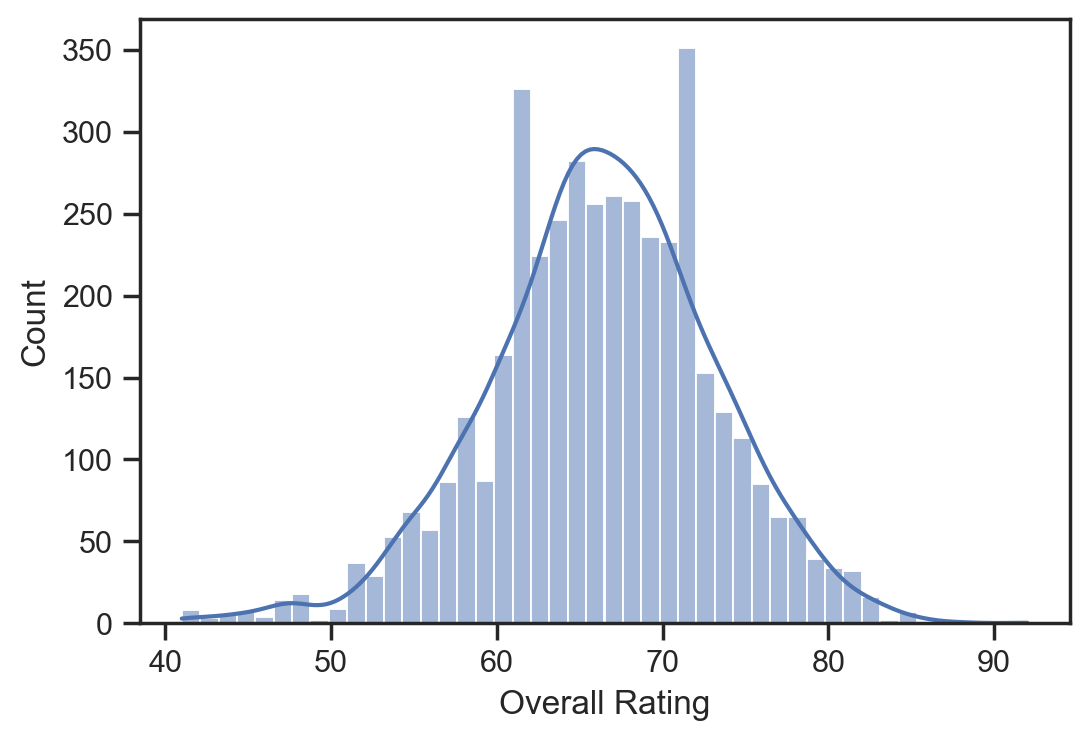

percentage of the rows with other values in the attacking_work_rate OR defensive_work_rate columns is:
 2.29%


In [35]:
df= pd.read_sql('''SELECT *
            FROM Player_Attributes 
            WHERE attacking_work_rate NOT IN ('medium', 'high', 'low') OR 
                defensive_work_rate NOT IN ('medium', 'high', 'low')
            ''', conn)



sns.histplot(df['overall_rating'], kde=True)
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()
percent = 100* df.shape[0] /INIT_NUM_ROW_PLAYER_ATTR
print(f'percentage of the rows with other values in the attacking_work_rate OR defensive_work_rate columns is:\n{percent: .2f}%' )

In [36]:
# delete the rows with other values 
cur.execute('''DELETE
            FROM Player_Attributes 
            WHERE attacking_work_rate NOT IN ('medium', 'high', 'low') OR 
                defensive_work_rate NOT IN ('medium', 'high', 'low')
            ''')

FINAL_NUM_ROW_PLAYER_ATTR = cur.execute("SELECT COUNT(*) FROM Player_Attributes").fetchone()[0] # 176161
NUM_PLAYER_FROM_PLAYER_ATTR = cur.execute("SELECT COUNT(DISTINCT player_fifa_api_id) FROM Player_Attributes").fetchone()[0] # 9926


<a id='eda'></a>
## Exploratory Data Analysis

We now load the tables into `pandas` data frames. Next, we join the `Player` and `Player_Attributes` data frames so that all relevant data is now in one place. We add the `date` column as a nother layer of indexing the data. This will help us in visualizaiton. Let's try answering the questions we raised in the introduction of this report. 

In [37]:
league = pd.read_sql('SELECT * FROM League', conn) # not used at all 
league.head()

league_id                    name  country
0          1  Belgium Jupiler League  Belgium
1       1729  England Premier League  England
2       4769          France Ligue 1   France
3       7809   Germany 1. Bundesliga  Germany
4      10257           Italy Serie A    Italy

In [38]:
player = pd.read_sql('SELECT * FROM Player', conn)
player['weight_kg'] = round(player['weight_kg'])
player.rename(columns={'weight': 'weight_lps'}, inplace=1)
player.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight_lps  weight_kg  
0  1992-02-29 00:00:00  182.88         187       85.0  
1  1989-12-15 00:00:00  170.18         146       66.0  
2  1991-05-13 00:00:00  170.18         163       74.0  
3  1982-05-08 00:00:00  182.88         198       90.0  
4  1979-11-08 00:00:00  182.88         154       70.0

In [39]:
player_attr = pd.read_sql('SELECT * FROM Player_Attributes', conn)
player_attr = player.merge(player_attr, on='player_fifa_api_id', how='inner') 
player_attr.drop(columns=['id_x', 'player_api_id_x', 'id_y', 'player_api_id_y'], inplace=True)
player_attr['date'] = pd.to_datetime(player_attr['date'])
player_attr.set_index('date', append=True, inplace=True)
max_dataframe(player_attr, 1)

player_name  player_fifa_api_id             birthday  \
  date                                                                      
0 2016-02-18  Aaron Appindangoye              218353  1992-02-29 00:00:00   
1 2015-11-19  Aaron Appindangoye              218353  1992-02-29 00:00:00   
2 2015-09-21  Aaron Appindangoye              218353  1992-02-29 00:00:00   
3 2015-03-20  Aaron Appindangoye              218353  1992-02-29 00:00:00   
4 2007-02-22  Aaron Appindangoye              218353  1992-02-29 00:00:00   

              height  weight_lps  weight_kg  overall_rating  potential  \
  date                                                                   
0 2016-02-18  182.88         187       85.0              67         71   
1 2015-11-19  182.88         187       85.0              67         71   
2 2015-09-21  182.88         187       85.0              62         66   
3 2015-03-20  182.88         187       85.0              61         65   
4 2007-02-22  182.88         187       85.0              61         65   

             preferred_foot attacking_work_rate defensive_work_rate  crossing  \
  date                                                                          
0 2016-02-18          right              medium              medium        49   
1 2015-11-19          right              medium              medium        49   
2 2015-09-21          right              medium              medium        49   
3 2015-03-20          right              medium              medium        48   
4 2007-02-22          right              medium              medium        48   

              finishing  heading_accuracy  short_passing  volleys  dribbling  \
  date                                                                         
0 2016-02-18         44                71             61       44         51   
1 2015-11-19         44                71             61       44         51   
2 2015-09-21         44                71             61       44         51   
3 2015-03-20         43                70             60       43         50   
4 2007-02-22         43                70             60       43         50   

              curve  free_kick_accuracy  long_passing  ball_control  \
  date                                                                
0 2016-02-18     45                  39            64            49   
1 2015-11-19     45                  39            64            49   
2 2015-09-21     45                  39            64            49   
3 2015-03-20     44                  38            63            48   
4 2007-02-22     44                  38            63            48   

              acceleration  sprint_speed  agility  reactions  balance  \
  date                                                                  
0 2016-02-18            60            64       59         47       65   
1 2015-11-19            60            64       59         47       65   
2 2015-09-21            60            64       59         47       65   
3 2015-03-20            60            64       59         46       65   
4 2007-02-22            60            64       59         46       65   

              shot_power  jumping  stamina  strength  long_shots  aggression  \
  date                                                                         
0 2016-02-18          55       58       54        76          35          71   
1 2015-11-19          55       58       54        76          35          71   
2 2015-09-21          55       58       54        76          35          63   
3 2015-03-20          54       58       54        76          34          62   
4 2007-02-22          54       58       54        76          34          62   

              interceptions  positioning  vision  penalties  marking  \
  date                                                                 
0 2016-02-18             70           45      54         48       65   
1 2015-11-19             70           45      

#### Who are the best (highest overall rating) players now and of all-time?

We list the best 10 players according to their latest ratings as well as the best 10 all-time players. After that, we plot line plots of the best 10 players recently to see thier history. Eden Hazard has the most impressive path as he went from around 50 in 2009 to 78 in 2010 to around 85 in 2012! 

In [40]:
grouped_player_attr = player_attr.sort_values('date', ascending=False).groupby('player_fifa_api_id')
latest_ratings = grouped_player_attr.head(1)
recent_best = latest_ratings.sort_values('overall_rating', ascending=False)
recent_best_10 = recent_best[:10]
# max_dataframe(best_10, 1)
display(recent_best_10[['player_fifa_api_id', 'player_name', 'overall_rating']])
recent_best_10_fifa_id = recent_best_10['player_fifa_api_id']

player_fifa_api_id         player_name  overall_rating
       date                                                              
98324  2015-12-17              158023        Lionel Messi              94
32016  2015-10-16               20801   Cristiano Ronaldo              93
104592 2016-04-21              167495        Manuel Neuer              90
101682 2015-10-16              176580         Luis Suarez              90
126067 2016-02-04              190871              Neymar              90
175894 2015-09-21               41236  Zlatan Ibrahimovic              89
15921  2016-01-28                9014        Arjen Robben              89
12375  2015-10-16                  41      Andres Iniesta              88
162606 2015-09-21              164240        Thiago Silva              88
45423  2016-01-28              183277         Eden Hazard              88

In [41]:
all_time_best = player_attr.sort_values('overall_rating', ascending=False).groupby('player_fifa_api_id').head(1)
all_time_best_10 = all_time_best[:10]
display(all_time_best_10[['player_fifa_api_id', 'player_name', 'overall_rating']])
all_time_best_10_fifa_id = all_time_best_10['player_fifa_api_id']

player_fifa_api_id        player_name  overall_rating
       date                                                             
98324  2015-12-17              158023       Lionel Messi              94
32018  2015-09-21               20801  Cristiano Ronaldo              93
171446 2007-02-22               54050       Wayne Rooney              93
61355  2007-02-22                1179   Gianluigi Buffon              93
173130 2011-08-30               10535     Xavi Hernandez              92
162822 2007-02-22                1625      Thierry Henry              91
69698  2008-08-30                5479      Iker Casillas              91
81388  2007-02-22               13732         John Terry              91
146999 2007-08-30               28130         Ronaldinho              91
12391  2011-08-30                  41     Andres Iniesta              91

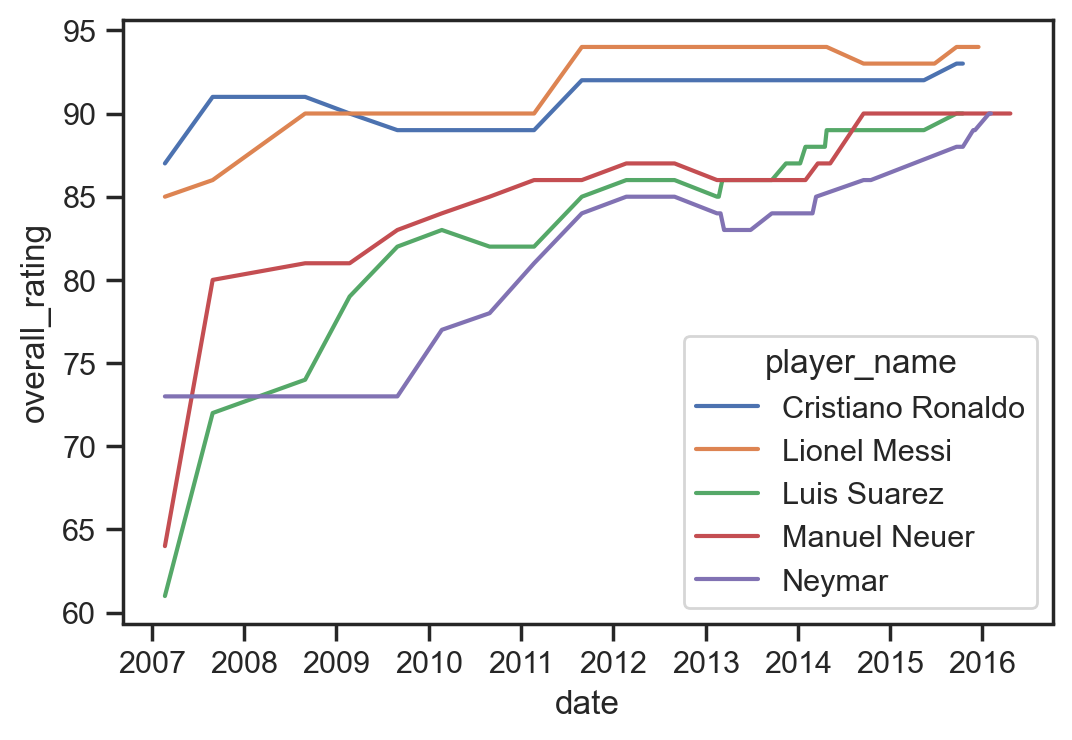

In [42]:
# I have to make a copy to avoid view and copy warning messages
recent_best_5_hist = player_attr[player_attr['player_fifa_api_id'].isin(recent_best_10_fifa_id[:5])].copy()

ax = sns.lineplot(x='date', y='overall_rating', hue='player_name' , data=recent_best_5_hist) # make hue_order as the ranking of the players

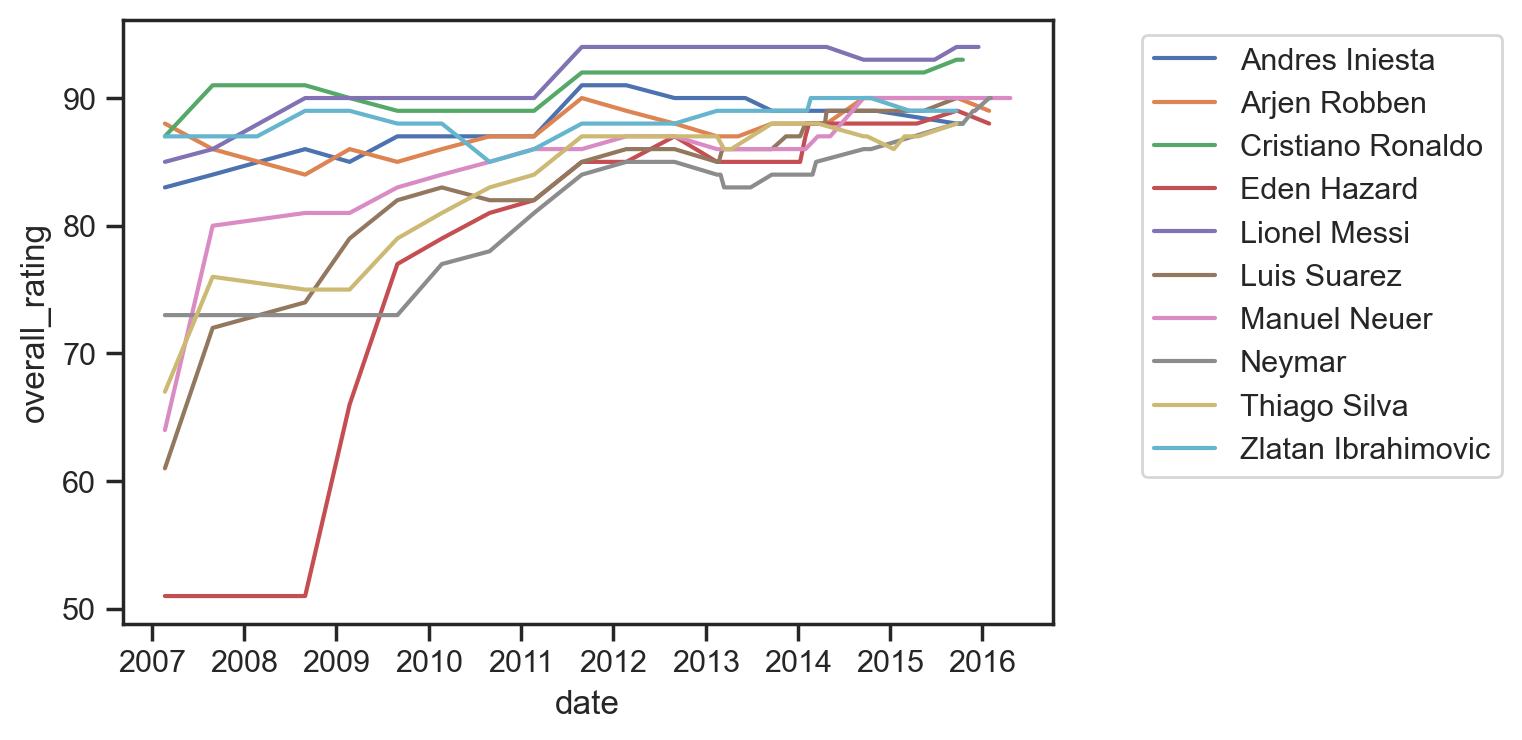

In [43]:
# I have to make a copy to avoid view and copy warning messages
recent_best_10_hist = player_attr[player_attr['player_fifa_api_id'].isin(recent_best_10_fifa_id)].copy()

ax = sns.lineplot(x='date', y='overall_rating', hue='player_name' , data=recent_best_10_hist) # make hue_order as the ranking of the players
plt.legend(bbox_to_anchor=(1.5, 1))
plt.show()

#### What are key factors of the best players?

This is a typical problem of PCA. However, it was beyond the scope of the course so I only relied on visualization. There are 38 variables that we can explore. If we drew a plot for each combination of two variables without repeatitions, we would have
$$
\frac{38!}{2!\cdot 36!} = 703 \quad \text{plots}
$$

We, therefore, decided to fix the y-axis to be the `overall_rating` column and search for the columns that seperate the best players from the rest in the x direction. This results in 37 plots. I hide them from the notebook and only include the result of exploring them. 

In order to avoid overlapping of the data points, we use the `alpha` from the `sns.scatterplot` function. We will use also a helper function `jitter` to vary the points a little around their true values since `(x,y)_jitter` is not functional in `seaborn` for now. 

In [44]:
df = latest_ratings.copy()
df['best_indicator'] = ''
df.loc[player_attr['player_fifa_api_id'].isin(recent_best_10_fifa_id), 'best_indicator'] = 'best 10'

In [45]:
%%capture
# comment the above line if you want to see the 36 plots 

exclude_cols = ['player_name', 'player_fifa_api_id', 'birthday','overall_rating', 'preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'best_indicator']
include_cols = [col for col in df.columns if col not in exclude_cols]
for col in include_cols:
    sns.scatterplot(x=jitter(df[col], 1), y=jitter(df['overall_rating'], 1), alpha=0.7, hue='best_indicator', data=df)
    plt.legend(bbox_to_anchor=(1.5, 1))
    plt.show()

One of the most notable things from the plots is that `strength` and `stamina` were not among the key factors of the best palyers. However, we know most of these players always play 90 minutes of almost every match. They work smart, not hard. They key factors we observed were `dribbling`, `ball_control`, `reactions`, `positioning`, and `vision`. We now try to produce several plots combining them to get the best result. I have created three 3d-scatter plots and I think that the three variables: `dribbling`, `positioning`, `ball_control` best describe the variation between the best palyers and the rest. 

In [46]:
fig = px.scatter_3d(df, x='dribbling', y='positioning', z='vision',
              color='best_indicator', size_max=0.1)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [47]:
fig = px.scatter_3d(df, x='dribbling', y='positioning', z='ball_control',
              color='best_indicator', size_max=0.1)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [48]:
fig = px.scatter_3d(df, x='dribbling', y='positioning', z='vision',
              color='best_indicator', size_max=0.1)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

#### Can we predict the overall rating of a player?

To further test the goodness of the key factors we found, we define a new column as the average of these three variables. Then, we plot a scatter plot of `overall_rating` against our new `predictor`. Since the variables are mostly about attacking, we strict the plotting to players with `attacking_work_rate = 'high'`. A weighted average of these variables is the same as building a multiple linear regression on them (with zero intercept). 

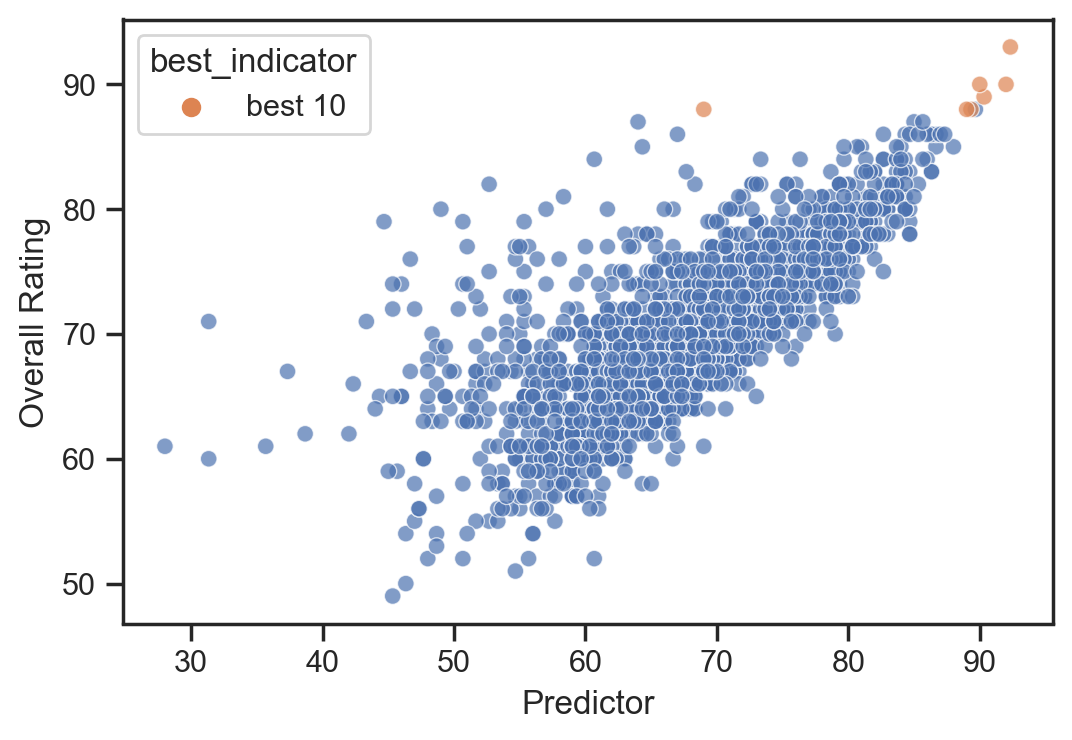

In [49]:
df['predictor'] = df.apply(lambda x: x[['dribbling', 'positioning', 'ball_control']].mean().round(2), axis=1)

sns.scatterplot(x='predictor', y='overall_rating', hue='best_indicator', alpha=0.7, data=df.loc[df['attacking_work_rate']=='high'])
plt.xlabel('Predictor')
plt.ylabel('Overall Rating')
plt.show()

We see that 9 of the 10 best players are well-separated from the other palyers depending on our predictor variable. Given that we only built our predictor on visualization of the data, we think it did very well predicting the overall rating of attacking players. 

#### Is football a right-footed sport?


Left-footers are essential parts of any team in left-back and wingers postions. However, it is hard to find a central midfielder, for example, that is left-footed. Can you? I can only think of Alex; the Brazilian retired footballer, who played as an attacking midfielder for the Turkish club Fenerbahçe. Here, I am trying to get insights of the percentage of left-footed players in football and see how they compare with other players. I use the latest rating of each player in this section. The next plot shows the number of left footed-players in our dataset. 

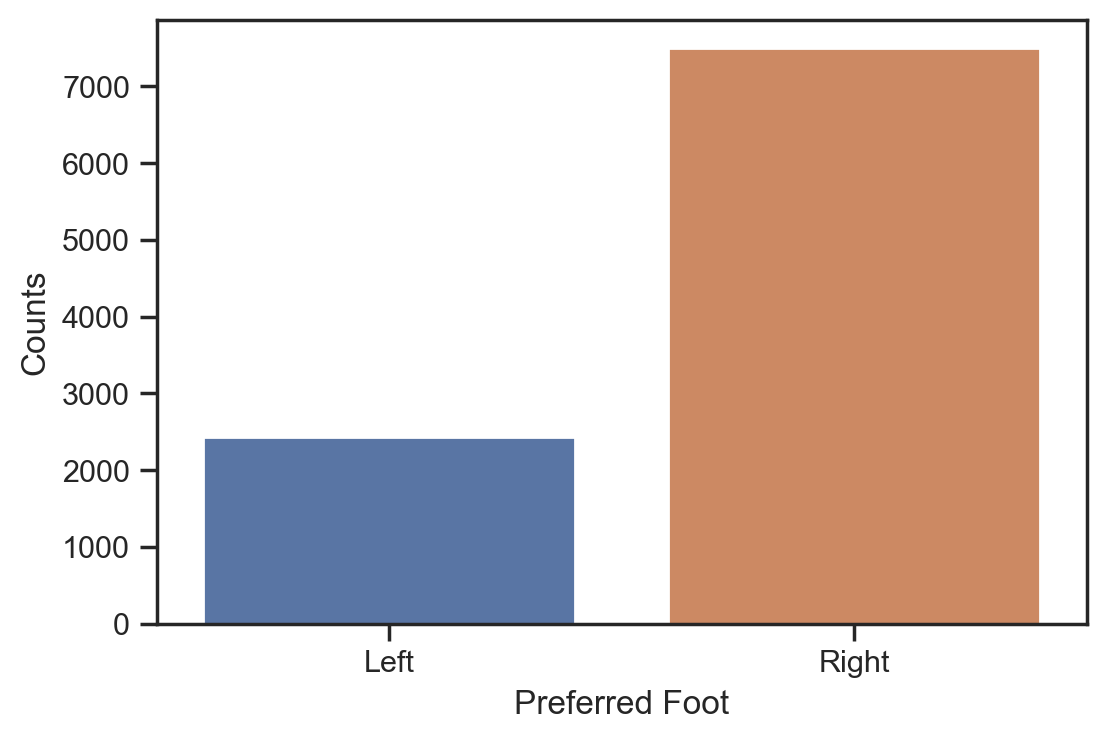

Percent of left-footed players in our dataset is:  24.49%


In [50]:
left = latest_ratings.loc[latest_ratings['preferred_foot']=='left', 'player_fifa_api_id'].nunique() 
n = latest_ratings['player_fifa_api_id'].nunique()
right = n - left 

ax = sns.barplot(x=['Left', 'Right'], y=[left, right], hue_order=['Left', 'Right'])
plt.xlabel('Preferred Foot')
plt.ylabel('Counts')
plt.show()

print(f'Percent of left-footed players in our dataset is: {100*left/n: .2f}%')


This might suggest that football is right-footed-dominated. However, our conclusion is incomplete without taking into account the percnetage of left-footed people in general. A recent [study](https://www.frontiersin.org/articles/10.3389/fpsyg.2016.01199/full) shows that $8.2\%$ of people are left-footed. In our dataset, we have $24.49\%$ left-footed players out of all players. Thus, it is the opposite of what the plot suggests. This is reasonable, however, given the structur of the football team. With at least one LB and one LW or LM in each football team, the team will have at least $\frac{2}{11}\sim 18\%$  of the team members reserved to left-footed players. If percentage of left-footers in the rest of the team's positions is the same as in the world population (i.e. the mentioned study), this will account for $0.08*82 \sim 6.56\%$. Thus, we expect the percentage of left-footers in footbal to be around $18+6.56 = 24.56\%$. This might be good news for left-footers who loves football.  

If we try to look at the overall rating and potential of each player. We see that left-footers and right-footers have the same relation between the two variables. Moreover, we can see from the plot below that they follow the same distribution. We also compute the average rating per a player in each category and we get very similar results between left ($68.29$) and right ($68.27$) footers. 

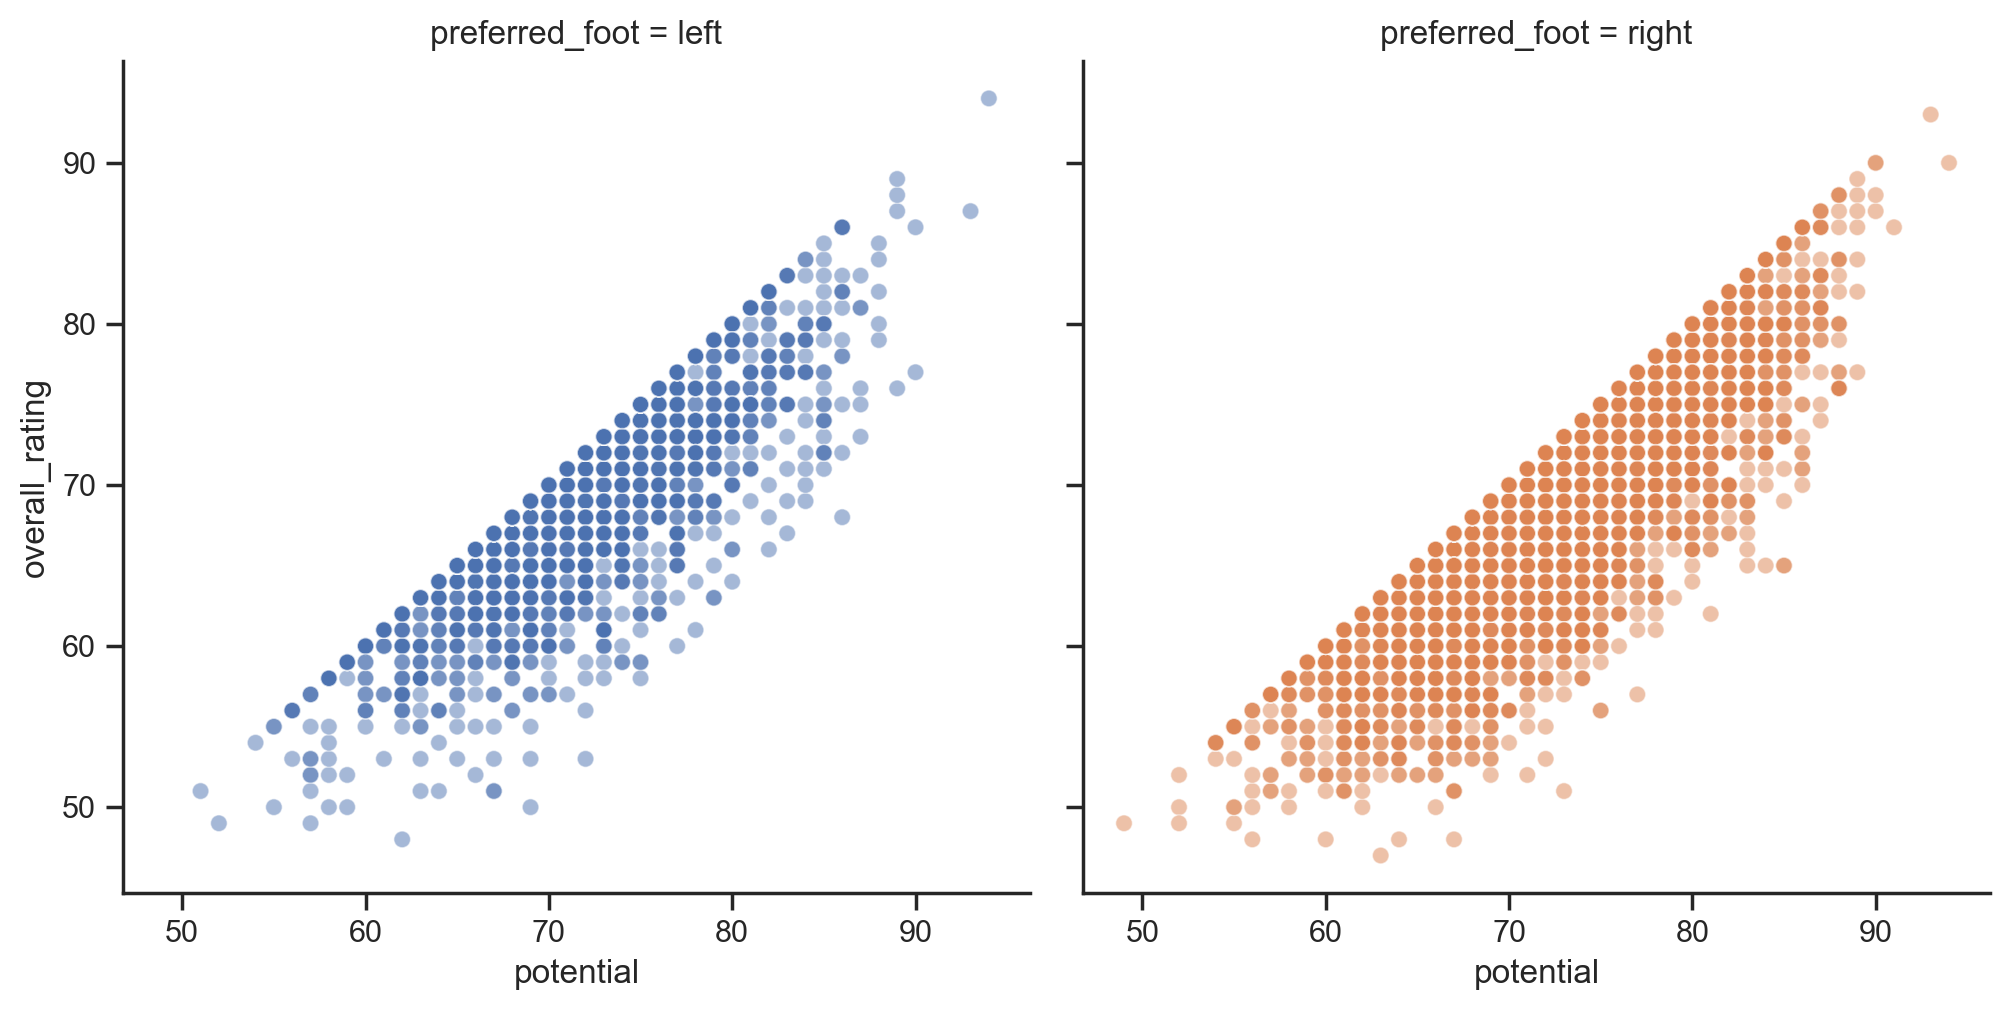

In [51]:
ax = sns.relplot(kind='scatter', x='potential', y='overall_rating', hue='preferred_foot', data=latest_ratings, alpha=0.5, col='preferred_foot', col_order=['left', 'right'], hue_order=['left', 'right'], legend=False)


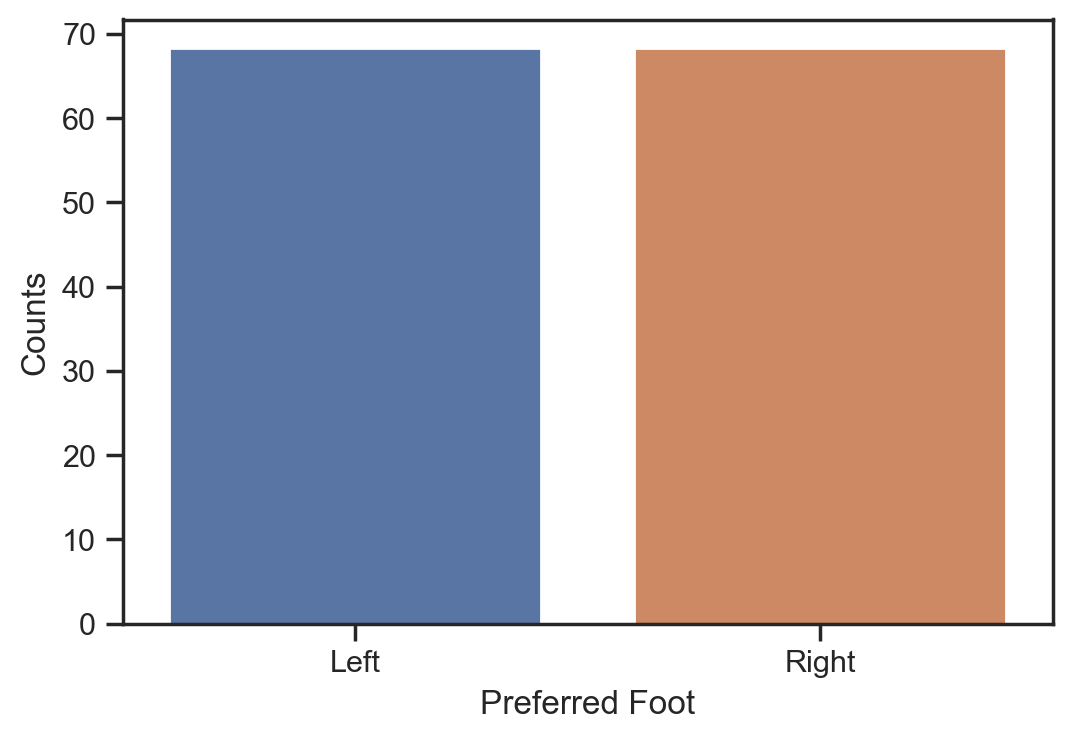

overall_rating
preferred_foot                
left                 68.290827
right                68.266177

In [52]:
df = latest_ratings.groupby('preferred_foot').agg({'overall_rating':'mean'})
ax = sns.barplot(x=df.index, y=df['overall_rating'], order=['left', 'right'])
plt.xticks(np.arange(2), ['Left', 'Right'])
plt.xlabel('Preferred Foot')
plt.ylabel('Counts')
plt.show()
display(df)

Finally, we look at the percentage of left-footed players among the recent and all time best 10 and 100 players. These result confirms that left-footed players are equally represented when we look at the recent or all-time best players and in football in general. 

In [53]:
names = list(recent_best_10.loc[recent_best_10['preferred_foot']=='left', 'player_name'])
n_left = len(names)
print(f'There are {n_left} left-footed player among the recent best 10 players. They are:\n{names}')

There are 2 left-footed player among the recent best 10 players. They are:
['Lionel Messi', 'Arjen Robben']


In [54]:
recent_best_100 = recent_best[:100]
names = list(recent_best_100.loc[recent_best_100['preferred_foot']=='left', 'player_name'])
n_left = len(names)
print(f'There are {n_left} left-footed player among the recent best 100 players. They are:\n{names}')

There are 20 left-footed player among the recent best 100 players. They are:
['Lionel Messi', 'Arjen Robben', 'Mesut Oezil', 'Gareth Bale', 'James Rodriguez', 'Giorgio Chiellini', 'Angel Di Maria', 'David Silva', 'Thibaut Courtois', 'Petr Cech', 'David Alaba', 'Hugo Lloris', 'Blaise Matuidi', 'Jordi Alba', 'Antoine Griezmann', 'Hulk', 'Daniel Sturridge', 'Luiz Gustavo', 'Douglas Costa', 'Marcelo']


In [55]:
names = list(all_time_best_10.loc[all_time_best_10['preferred_foot']=='left', 'player_name'])
n_left = len(names)
print(f'There are {n_left} left-footed player among the all-time best 10 players. They are:\n{names}')

There are 2 left-footed player among the all-time best 10 players. They are:
['Lionel Messi', 'Iker Casillas']


In [56]:
all_time_best_100 = all_time_best[:100]
names = list(all_time_best_100.loc[all_time_best_100['preferred_foot']=='left', 'player_name'])
n_left = len(names)
print(f'There are {n_left} left-footed player among the all-time best 100 players. They are:\n{names}')

There are 22 left-footed player among the all-time best 100 players. They are:
['Lionel Messi', 'Iker Casillas', 'Ze Roberto', 'Arjen Robben', 'Julio Cesar', 'Robin van Persie', 'Petr Cech', 'Adriano', 'David Silva', 'Mesut Oezil', 'Vicente', 'Dida', 'Florent Malouda', 'James Rodriguez', 'Rafael van der Vaart', 'Giorgio Chiellini', 'Juan Mata', 'Gareth Bale', 'Lukas Podolski', 'Kakha Kaladze', 'Angel Di Maria', 'Ryan Giggs']


<a id='conclusions'></a>
## Conclusions




<a id='limitations'></a>
## Limitations


Our prediction is not very good and it only concerns with attacking players. elaborate....

The following shows inconsistency in the data we have. elaborate....

In [57]:
n1 = player_attr.loc[player_attr['preferred_foot']=='left', 'player_fifa_api_id'].nunique()
n2 = latest_ratings.loc[latest_ratings['preferred_foot']=='left', 'player_fifa_api_id'].nunique()
print(n1, n2)

2909 2431


In [58]:
m1 = player_attr.loc[:, 'player_fifa_api_id'].nunique()
m2 = latest_ratings.loc[:, 'player_fifa_api_id'].nunique()
print(m1, m2)

9926 9926
